In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import pandas as pd
from IPython.display import Audio, display

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
def scan_audio_dataset(data_dir=r'E:/GoogleAudioSet/raw_audio/segmented_audio'):
    """Scan the dataset and collect metadata"""
    dataset_info = []

    # Target classes
    target_classes = [
        "Alarm clock",
        "Explosion", 
        "Gunshot, gunfire",
        "Siren",
        "Vehicle horn, car horn, honking"
    ]
    
    print(f"Scanning directory: {data_dir}")

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Only process target classes
        if class_name not in target_classes:
            print(f"Skipping class: {class_name} (not in target classes)")
            continue
            
        print(f"Processing class: {class_name}")
        
        for audio_file in os.listdir(class_path):
            # Support WAV, MP3, and other common formats
            if audio_file.lower().endswith(('.wav', '.mp3', '.flac', '.ogg')):
                file_path = os.path.join(class_path, audio_file)
                
                try:
                    # Load audio to get metadata
                    y, sr = librosa.load(file_path, sr=None, duration=0.1)  # Load just a bit for metadata
                    
                    # Get actual duration
                    duration = librosa.get_duration(path=file_path)
                    
                    dataset_info.append({
                        'class': class_name,
                        'filename': audio_file,
                        'path': file_path,
                        'duration_sec': duration,
                        'sample_rate': sr,
                        'channels': 1 if y.ndim == 1 else y.shape[0]
                    })
                except Exception as e:
                    print(f"Error loading {audio_file}: {e}")
    
    return pd.DataFrame(dataset_info)
    
# Scan dataset
print("Scanning dataset...")
df = scan_audio_dataset()

Scanning dataset...
Scanning directory: E:/GoogleAudioSet/raw_audio/segmented_audio
Processing class: Alarm clock
Processing class: Explosion
Processing class: Gunshot, gunfire
Processing class: Siren
Processing class: Vehicle horn, car horn, honking


In [4]:
# Display overview
if len(df) == 0:
    print("\n" + "="*60)
    print("ERROR: No audio files found!")
    print("="*60)
    print("\nPlease check:")
    print("1. The path exists: E:\\GoogleAudioSet\\raw_audio\\segmented_audio")
    print("2. Subdirectories match class names exactly")
    print("3. Audio files exist in those subdirectories")
else:
    # Display overview
    print("\n" + "="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    print(f"\nTotal audio files: {len(df)}")
    print(f"\nClass distribution:")
    print(df['class'].value_counts())

    print("\n" + "="*60)
    print("AUDIO STATISTICS")
    print("="*60)
    print(f"\nDuration Statistics (seconds):")
    print(df.groupby('class')['duration_sec'].describe())


DATASET OVERVIEW

Total audio files: 918

Class distribution:
class
Siren                              200
Explosion                          198
Gunshot, gunfire                   198
Vehicle horn, car horn, honking    198
Alarm clock                        124
Name: count, dtype: int64

AUDIO STATISTICS

Duration Statistics (seconds):
                                 count      mean       std     min  25%  50%  \
class                                                                          
Alarm clock                      124.0  2.000000  0.000000  2.0000  2.0  2.0   
Explosion                        198.0  2.000000  0.000000  2.0000  2.0  2.0   
Gunshot, gunfire                 198.0  2.000000  0.000000  2.0000  2.0  2.0   
Siren                            200.0  2.000000  0.000000  2.0000  2.0  2.0   
Vehicle horn, car horn, honking  198.0  1.997639  0.033224  1.5325  2.0  2.0   

                                 75%  max  
class                                      
Alarm clock

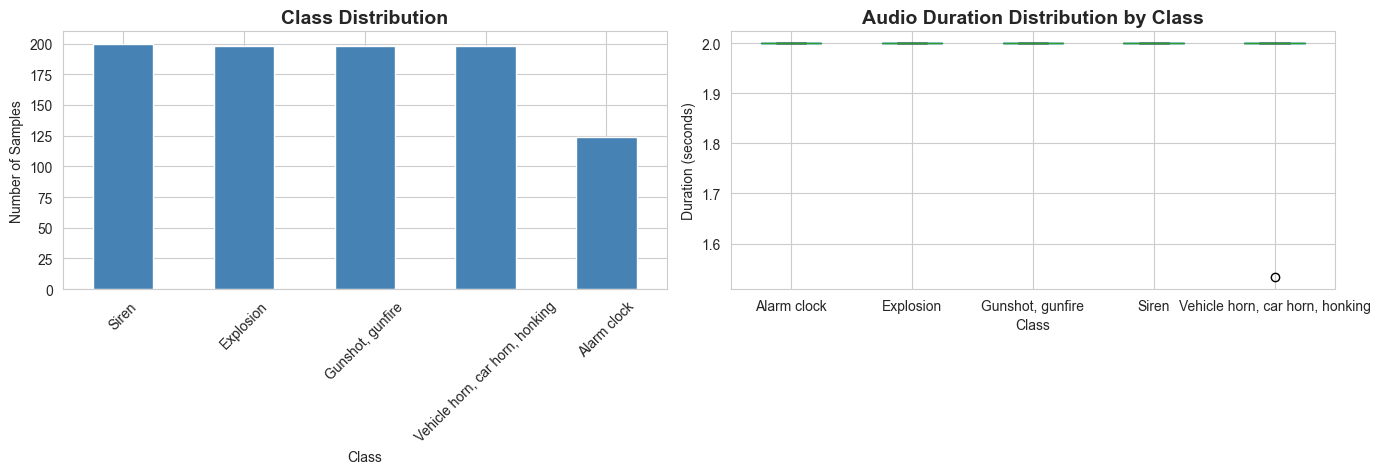

In [5]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['class'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Duration boxplot
df.boxplot(column='duration_sec', by='class', ax=axes[1])
axes[1].set_title('Audio Duration Distribution by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Duration (seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


AUDIO SAMPLES VISUALIZATION

Analyzing: Alarm clock - -74dab6wYqU_30.wav


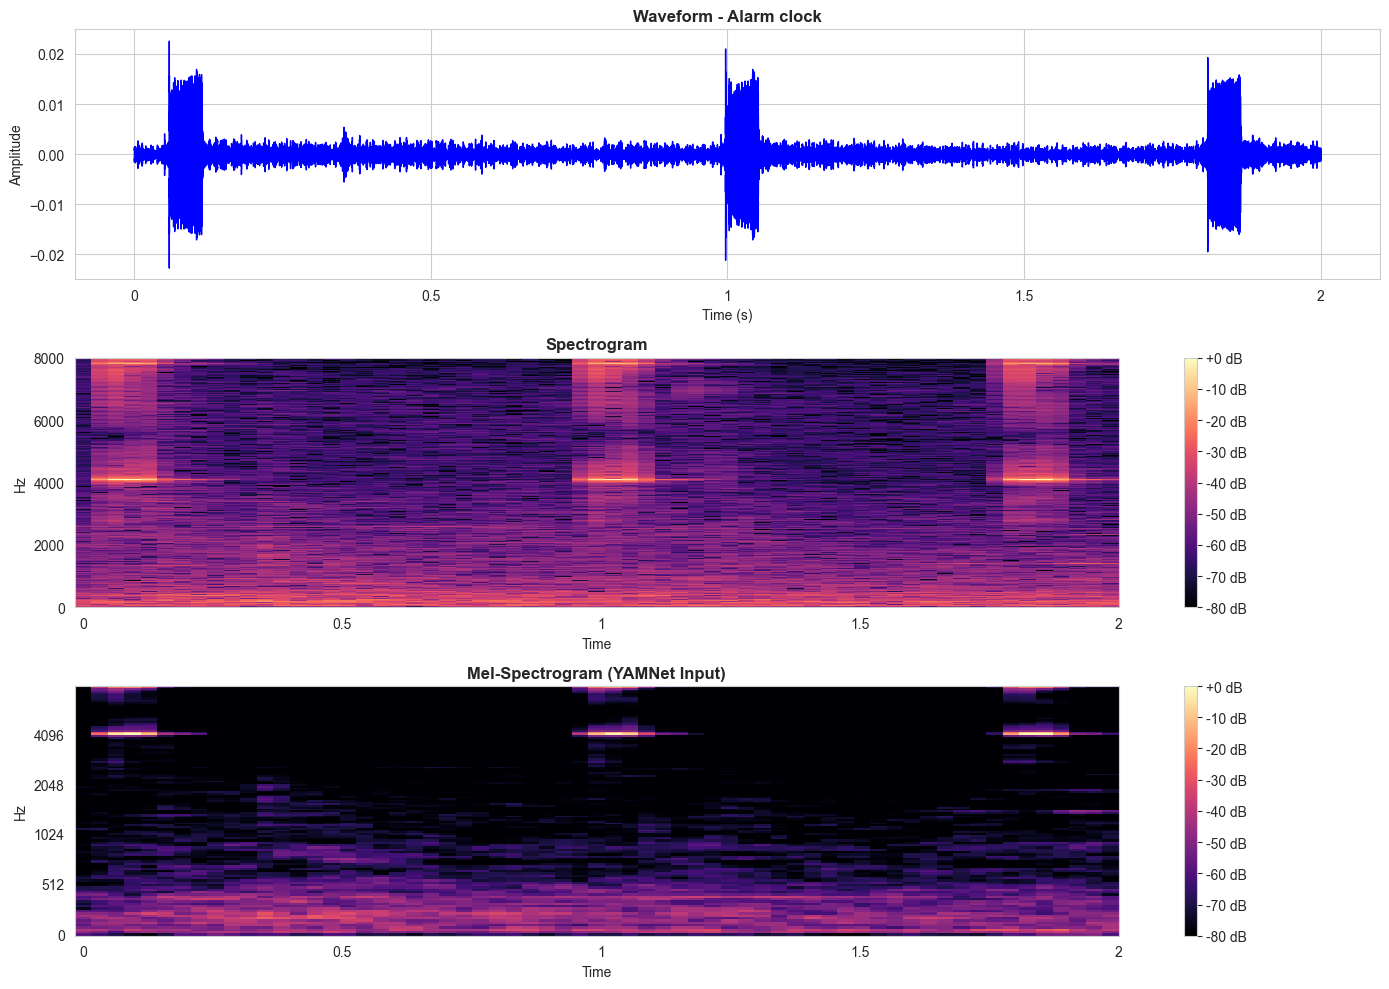

Playing audio from class: Alarm clock



Analyzing: Explosion - -1Hu_O-dosg_30.wav


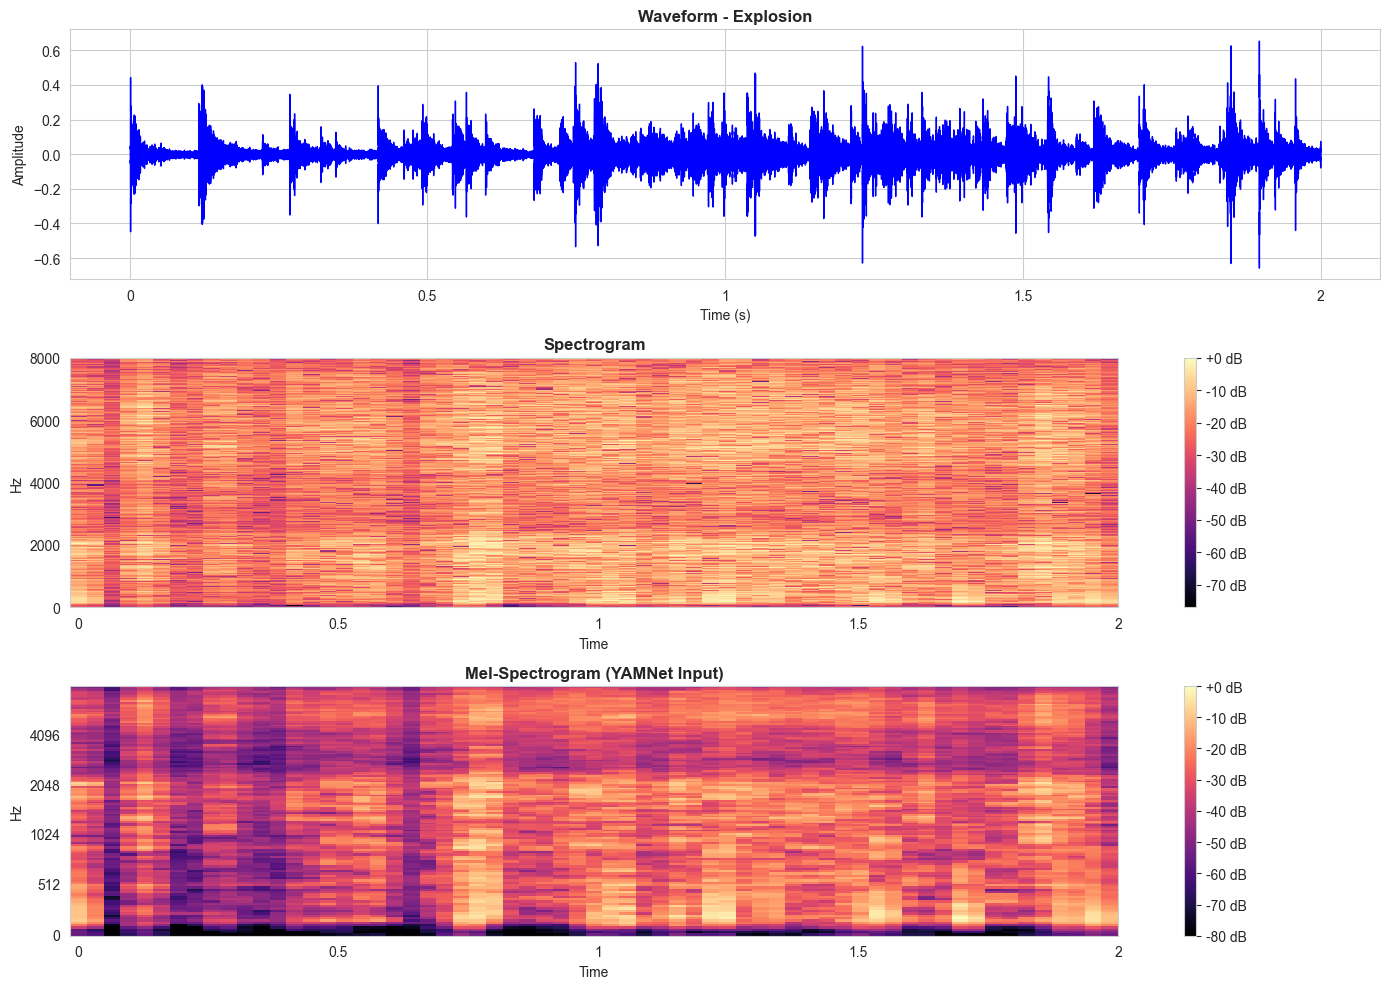

Playing audio from class: Explosion



Analyzing: Gunshot, gunfire - --PG66A3lo4_80.wav


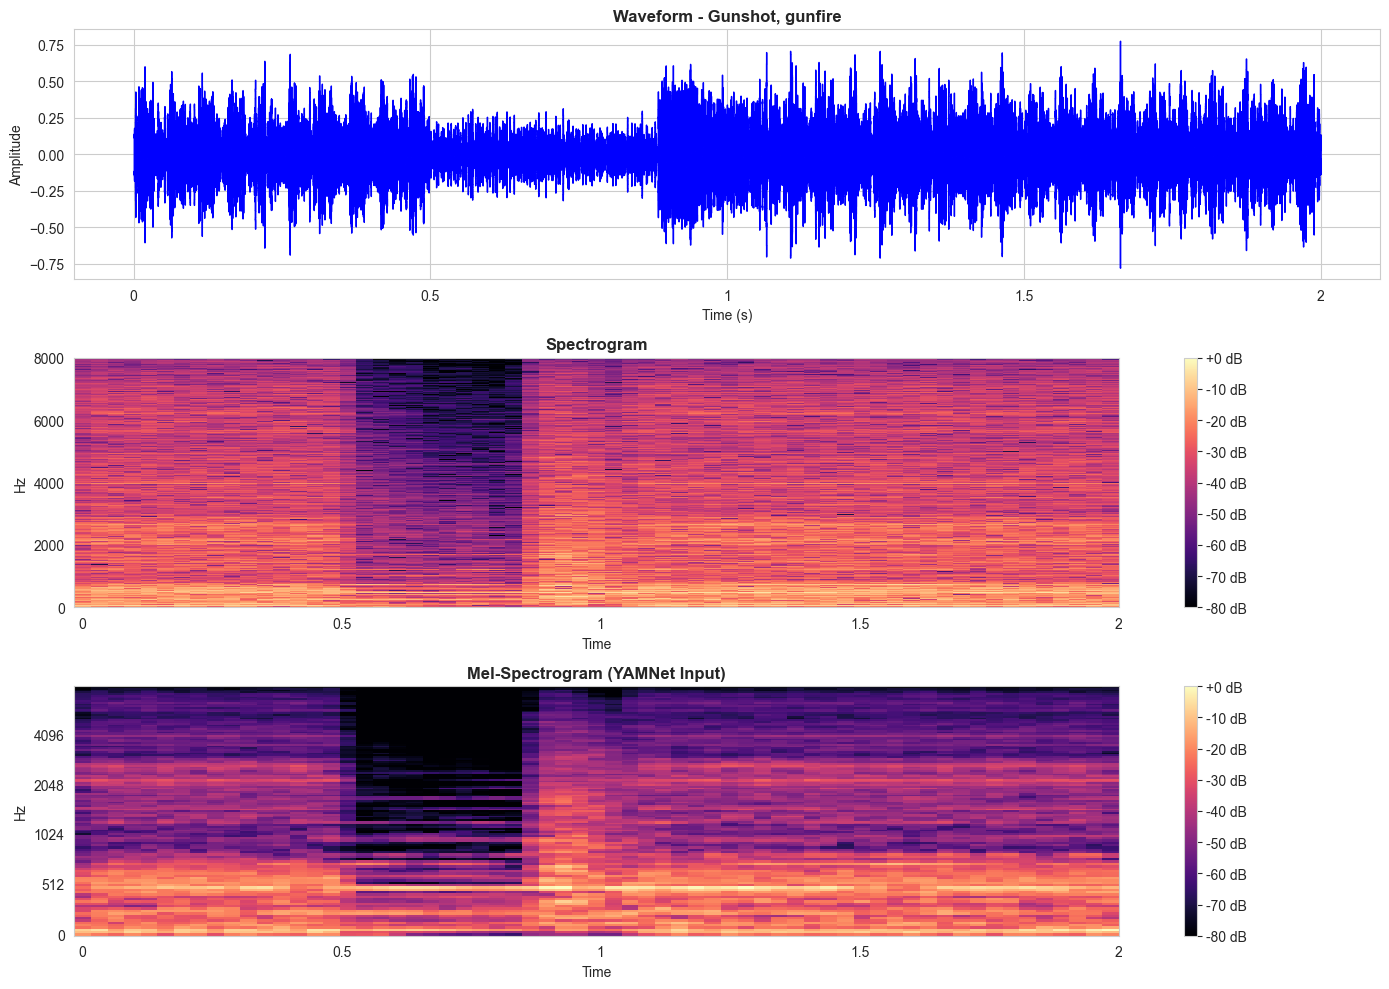

Playing audio from class: Gunshot, gunfire



Analyzing: Siren - -0Eem_FuIto_15.wav


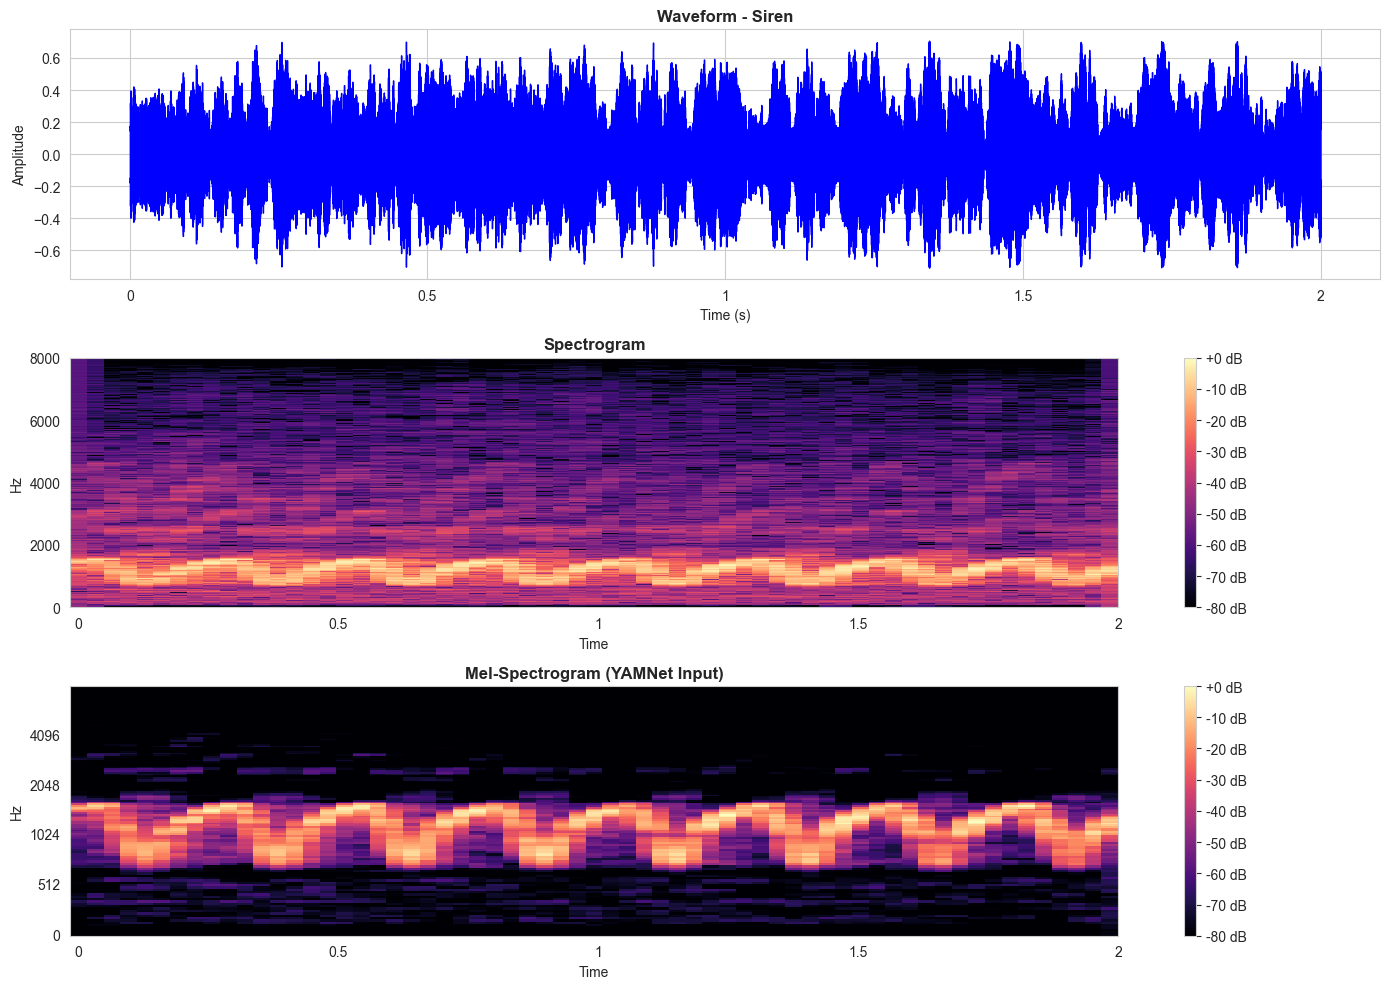

Playing audio from class: Siren



Analyzing: Vehicle horn, car horn, honking - -0qVjqx4X-E_30.wav


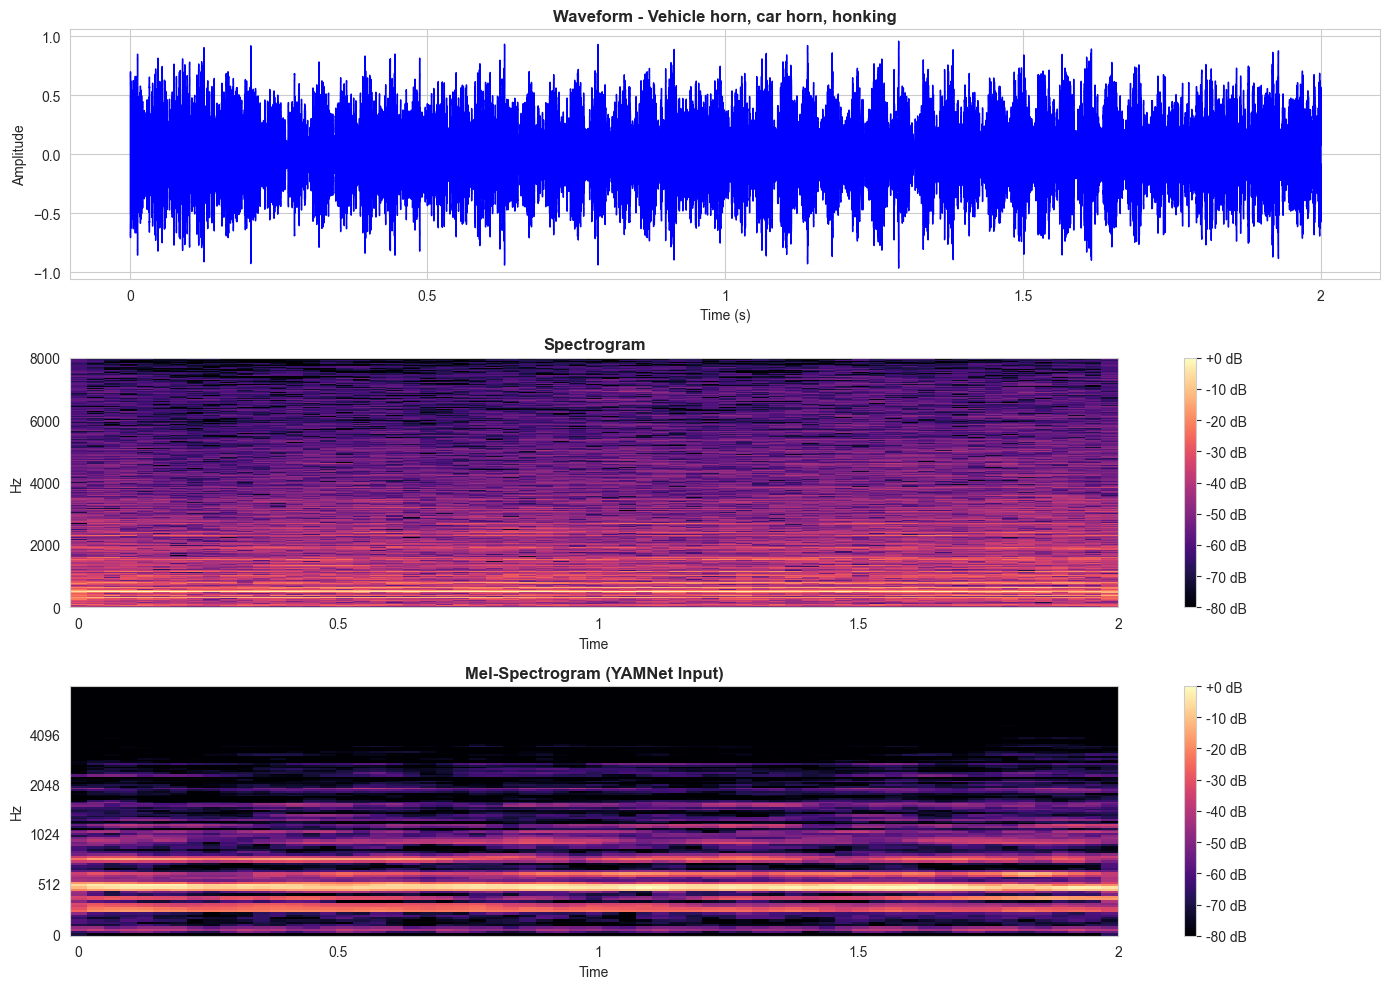

Playing audio from class: Vehicle horn, car horn, honking


In [6]:
def plot_audio_sample(file_path, class_name):
    """Plot waveform and spectrogram for an audio sample"""
    # Load audio
    y, sr = librosa.load(file_path, sr=16000)  # YAMNet uses 16kHz
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color="b")
    axes[0].set_title(f'Waveform - {class_name}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram', fontsize=12, fontweight='bold')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # Mel-spectrogram (what YAMNet uses)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Mel-Spectrogram (YAMNet Input)', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Play audio
    print(f"Playing audio from class: {class_name}")
    display(Audio(file_path))

# Visualize one sample from each class
print("\n" + "="*60)
print("AUDIO SAMPLES VISUALIZATION")
print("="*60)

for class_name in df['class'].unique():
    sample = df[df['class'] == class_name].iloc[0]
    print(f"\nAnalyzing: {class_name} - {sample['filename']}")
    plot_audio_sample(sample['path'], class_name)


EXTRACTING AUDIO FEATURES...


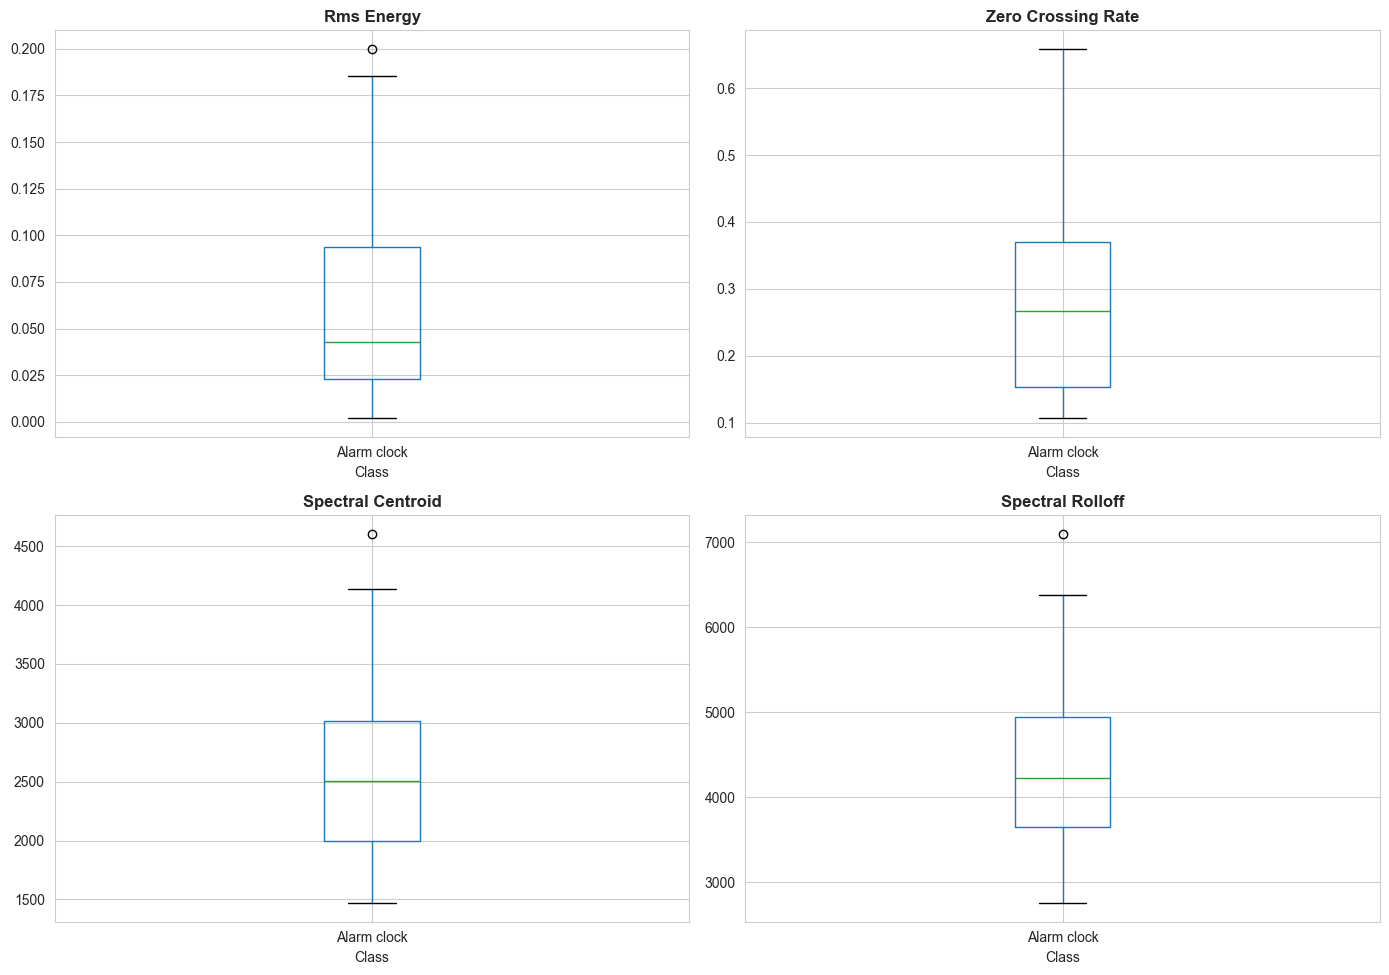

In [7]:
def extract_audio_features(file_path):
    """Extract basic audio features"""
    y, sr = librosa.load(file_path, sr=16000)
    
    features = {
        'duration': len(y) / sr,
        'rms_energy': np.mean(librosa.feature.rms(y=y)),
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
        'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    }
    return features

print("\n" + "="*60)
print("EXTRACTING AUDIO FEATURES...")
print("="*60)
# Extract features for a subset
feature_list = []
sample_size = min(20, len(df))
for idx, row in df.head(sample_size).iterrows():
    try:
        features = extract_audio_features(row['path'])
        features['class'] = row['class']
        feature_list.append(features)
    except Exception as e:
        print(f"Error extracting features from {row['filename']}: {e}")

if len(feature_list) > 0:
    feature_df = pd.DataFrame(feature_list)

    # Visualize features
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    features_to_plot = ['rms_energy', 'zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff']
    for idx, feature in enumerate(features_to_plot):
        ax = axes[idx // 2, idx % 2]
        feature_df.boxplot(column=feature, by='class', ax=ax)
        ax.set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Class')
        plt.suptitle('')

    plt.tight_layout()
    plt.show()